# 🎯 Black-Box Uncertainty Quantification

<div style="background-color: rgba(200, 200, 200, 0.1); padding: 20px; border-radius: 8px; margin-bottom: 20px; border: 1px solid rgba(127, 127, 127, 0.2); max-width: 97.5%; overflow-wrap: break-word;">
  <p style="font-size: 16px; line-height: 1.6">
    Black-box Uncertainty Quantification (UQ) methods treat the LLM as a black box and evaluate 
    consistency of multiple responses generated from the same prompt to estimate response-level confidence. This demo provides an illustration 
    of how to use state-of-the-art black-box UQ methods with <code>uqlm</code>. The available scorers and papers from which they are adapted are below:
  </p>
      
*   Discrete Semantic Entropy ([Farquhar et al., 2024](https://www.nature.com/articles/s41586-024-07421-0); [Kuhn et al., 2023](https://arxiv.org/pdf/2302.09664))
*   Number of Semantic Sets ([Lin et al., 2024](https://arxiv.org/abs/2305.19187); [Vashurin et al., 2025](https://arxiv.org/abs/2406.15627); [Kuhn et al., 2023](https://arxiv.org/pdf/2302.09664))
*   Non-Contradiction Probability ([Chen & Mueller, 2023](https://arxiv.org/abs/2308.16175); [Lin et al., 2024](https://arxiv.org/abs/2305.19187); [Manakul et al., 2023](https://arxiv.org/abs/2303.08896))
*   Entailment Probability ([Lin et al., 2025](https://arxiv.org/abs/2305.19187); [Chen & Mueller, 2023](https://arxiv.org/abs/2308.16175))
*   Exact Match ([Cole et al., 2023](https://arxiv.org/abs/2305.14613); [Chen & Mueller, 2023](https://arxiv.org/abs/2308.16175))
*   BERTScore ([Manakul et al., 2023](https://arxiv.org/abs/2303.08896); [Zheng et al., 2020](https://arxiv.org/abs/1904.09675))
*   Normalized Cosine Similarity ([Shorinwa et al., 2024](https://arxiv.org/pdf/2412.05563); [HuggingFace](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2))

</div>

## 📊 What You'll Do in This Demo

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>1</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section1>Set up LLM and prompts.</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Set up LLM instance and load example data prompts.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>2</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section2>Generate LLM Responses and Confidence Scores</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Generate and score LLM responses to the example questions using the <code>BlackBoxUQ()</code> class.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 25px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>3</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section3>Evaluate Hallucination Detection Performance</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Visualize model accuracy at different thresholds of the various black-box UQ confidence scores. Compute precision, recall, and F1-score of hallucination detection.</p>
  </div>
</div>

## ⚖️ Advantages & Limitations

<div style="display: flex; gap: 20px">
  <div style="flex: 1; background-color: rgba(0, 200, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(0, 200, 0, 0.2)">
    <h3 style="color: #2e8b57; margin-top: 0">Pros</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Universal Compatibility:</strong> Works with any LLM</li>
      <li><strong>Intuitive:</strong> Easy to understand and implement</li>
      <li><strong>No Internal Access Required:</strong> Doesn't need token probabilities or model internals</li>
    </ul>
  </div>
  
  <div style="flex: 1; background-color: rgba(200, 0, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(200, 0, 0, 0.2)">
    <h3 style="color: #b22222; margin-top: 0">Cons</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Higher Cost:</strong> Requires multiple generations per prompt</li>
      <li><strong>Slower:</strong> Multiple generations and comparison calculations increase latency</li>
    </ul>
  </div>
</div>

In [1]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

from uqlm import BlackBoxUQ
from uqlm.utils import load_example_dataset, plot_model_accuracies, LLMGrader, Tuner

## 1. Set up LLM and Prompts

In this demo, we will illustrate this approach using a set of short answer questions from the [PopQA benchmark](https://arxiv.org/abs/2212.10511). To implement with your use case, simply **replace the example prompts with your data**.  

In [2]:
# Load example dataset (popqa)
popqa = load_example_dataset("popqa", n=200)
popqa.head()

Loading dataset - popqa...


Repo card metadata block was not found. Setting CardData to empty.


Processing dataset...
Dataset ready!


,question,answer
0,What is George Rankin's occupation?,"[politician, political leader, political figur..."
1,What is John Mayne's occupation?,"[journalist, journo, journalists]"
2,What is Henry Feilden's occupation?,"[politician, political leader, political figur..."
3,What is Kathy Saltzman's occupation?,"[politician, political leader, political figur..."
4,What is Eleanor Davis's occupation?,"[cartoonist, graphic artist, animator, illustr..."


In [3]:
# Define prompts
INSTRUCTION = "You will be given a question. Return only the answer as concisely as possible without providing an explanation.\n"
prompts = [INSTRUCTION + prompt for prompt in popqa.question]

In this example, we use `AzureChatOpenAI` to instantiate our LLM, but any [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/) may be used. Be sure to **replace with your LLM of choice.**

In [4]:
# import sys
# !{sys.executable} -m pip install langchain-openai

## User to populate .env file with API credentials
from dotenv import load_dotenv, find_dotenv
from langchain_openai import AzureChatOpenAI

load_dotenv(find_dotenv())
llm = AzureChatOpenAI(
    deployment_name="o3-mini",
    openai_api_type="azure",
    openai_api_version="2024-12-01-preview",
    temperature=1,  # User to set temperature
)

## 2. Generate LLM Responses and Confidence Scores

### `BlackBoxUQ()` - Generate LLM responses and compute consistency-based confidence scores for each response.

![Sample Image](https://raw.githubusercontent.com/cvs-health/uqlm/develop/assets/images/black_box_graphic.png)

#### 📋 Class Attributes

<table style="border-collapse: collapse; width: 100%; border: 1px solid rgba(127, 127, 127, 0.2);">
  <tr>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 20%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Parameter</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 25%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Type & Default</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 55%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Description</th>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">llm</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BaseChatModel<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">A langchain llm `BaseChatModel`. User is responsible for specifying temperature and other relevant parameters to the constructor of the provided `llm` object.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">scorers</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">List[str]<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies which black box (consistency) scorers to include. Must be subset of ['semantic_negentropy', 'noncontradiction', 'exact_match', 'bert_score', 'cosine_sim', 'entailment', 'semantic_sets_confidence']. If None, defaults to ["semantic_negentropy", "noncontradiction", "exact_match", "cosine_sim"]. Note that using "bleurt" is deprecated as of <code>v0.2.0</code>.</td>
  </tr>    
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">device</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str or torch.device<br><code>default="cpu"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies the device that NLI model use for prediction. Only applies to 'semantic_negentropy', 'noncontradiction' scorers. Pass a torch.device to leverage GPU.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">use_best</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">bool<br><code>default=True</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies whether to swap the original response for the uncertainty-minimized response among all sampled responses based on semantic entropy clusters. Only used if `scorers` includes 'semantic_negentropy' or 'noncontradiction'.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">system_prompt</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str or None<br><code>default="You are a helpful assistant."</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Optional argument for user to provide custom system prompt for the LLM.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">max_calls_per_min</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">int<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies how many API calls to make per minute to avoid rate limit errors. By default, no limit is specified.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">use_n_param</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">bool<br><code>default=False</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies whether to use <code>n</code> parameter for <code>BaseChatModel</code>. Not compatible with all <code>BaseChatModel</code> classes. If used, it speeds up the generation process substantially when <code>num_responses</code> is large.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">postprocessor</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">callable<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">A user-defined function that takes a string input and returns a string. Used for postprocessing outputs.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">sampling_temperature</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">float<br><code>default=1</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">The 'temperature' parameter for LLM to use when generating sampled LLM responses. Must be greater than 0.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">nli_model_name</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str<br><code>default="microsoft/deberta-large-mnli"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies which NLI model to use. Must be acceptable input to <code>AutoTokenizer.from_pretrained()</code> and <code>AutoModelForSequenceClassification.from_pretrained()</code>.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">max_length</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">int<br><code>default=2000</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies the maximum allowed string length for LLM responses for NLI computation. Responses longer than this value will be truncated in NLI computations to avoid <code>OutOfMemoryError</code>.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">return_responses</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str<br><code>default="all"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">If a postprocessor is used, specifies whether to return only postprocessed responses, only raw responses, or both. Specified with 'postprocessed', 'raw', or 'all', respectively.</td>
  </tr>
</table>

#### 🔍 Parameter Groups

<div style="display: flex; gap: 20px; margin-bottom: 20px">
  <div style="flex: 1; padding: 10px; background-color: rgba(0, 100, 200, 0.1); border-radius: 5px; border: 1px solid rgba(0, 100, 200, 0.2);">
    <p style="font-weight: bold">🧠 LLM-Specific</p>
    <ul>
      <li><code>llm</code></li>
      <li><code>system_prompt</code></li>
      <li><code>sampling_temperature</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(0, 200, 0, 0.1); border-radius: 5px; border: 1px solid rgba(0, 200, 0, 0.2);">
    <p style="font-weight: bold">📊 Confidence Scores</p>
    <ul>
      <li><code>scorers</code></li>
      <li><code>use_best</code></li>
      <li><code>nli_model_name</code></li>
      <li><code>postprocessor</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(200, 150, 0, 0.1); border-radius: 5px; border: 1px solid rgba(200, 150, 0, 0.2);">
    <p style="font-weight: bold">🖥️ Hardware</p>
    <ul>
      <li><code>device</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(200, 0, 200, 0.1); border-radius: 5px; border: 1px solid rgba(200, 0, 200, 0.2);">
    <p style="font-weight: bold">⚡ Performance</p>
    <ul>
      <li><code>max_calls_per_min</code></li>
      <li><code>use_n_param</code></li>
    </ul>
  </div>
</div>

#### 💻 Usage Examples

```python
# Basic usage with default parameters
bbuq = BlackBoxUQ(llm=llm)

# Using GPU acceleration, default scorers
bbuq = BlackBoxUQ(llm=llm, device=torch.device("cuda"))

# Custom scorer list
bbuq = BlackBoxUQ(llm=llm, scorers=["semantic_negentropy", "exact_match", "cosine_sim"])

# High-throughput configuration with rate limiting
bbuq = BlackBoxUQ(llm=llm, max_calls_per_min=200, use_n_param=True) 
```

In [5]:
import torch

# Set the torch device
if torch.cuda.is_available():  # NVIDIA GPU
    device = torch.device("cuda")
elif torch.backends.mps.is_available():  # macOS
    device = torch.device("mps")
else:
    device = torch.device("cpu")  # CPU
print(f"Using {device.type} device")

Using cuda device


In [6]:
black_box_scorers = ["noncontradiction", "semantic_negentropy", "cosine_sim"]
bbuq = BlackBoxUQ(llm=llm, max_calls_per_min=150, device=device, scorers=black_box_scorers)

### 🔄 Class Methods

<table style="border-collapse: collapse; width: 100%; border: 1px solid rgba(127, 127, 127, 0.2);">
  <tr>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 25%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Method</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 75%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Description & Parameters</th>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BlackBoxUQ.generate_and_score</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">
      <p>Generate LLM responses, sampled LLM (candidate) responses, and compute confidence scores for the provided prompts.</p>
      <p><strong>Parameters:</strong></p>
      <ul>
        <li><code>prompts</code> - (<strong>List[str] or List[List[BaseMessage]]</strong>) A list of input prompts for the model.</li>
        <li><code>num_responses</code> - (<strong>int, default=5</strong>) The number of sampled responses used to compute consistency.</li>
        <li><code>show_progress_bars</code> - (<strong>bool, default=True</strong>) If True, displays a progress bar while generating and scoring responses.</li>        
      </ul>
      <p><strong>Returns:</strong> <code>UQResult</code> containing data (prompts, responses, sampled responses, and confidence scores) and metadata</p>
      <div style="background-color: rgba(0, 200, 0, 0.1); padding: 8px; border-radius: 3px; margin-top: 10px; border: 1px solid rgba(0, 200, 0, 0.2); margin-right: 5px; box-sizing: border-box; width: 100%;">
        <strong>💡 Best For:</strong> Complete end-to-end uncertainty quantification when starting with prompts.
      </div>
    </td>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BlackBoxUQ.score</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">
      <p>Compute confidence scores on provided LLM responses. Should only be used if responses and sampled responses are already generated.</p>
      <p><strong>Parameters:</strong></p>
      <ul>
        <li><code>responses</code> - (<strong>List[str]</strong>) A list of LLM responses for the prompts.</li>
        <li><code>sampled_responses</code> - (<strong>List[List[str]]</strong>) A list of lists of sampled LLM responses for each prompt. Used to compute consistency scores by comparing to the corresponding response from <code>responses</code>.</li>
        <li><code>show_progress_bars</code> - (<strong>bool, default=True</strong>) If True, displays a progress bar while scoring responses.</li>  
      </ul>
      <p><strong>Returns:</strong> <code>UQResult</code> containing data (responses, sampled responses, and confidence scores) and metadata</p>
      <div style="background-color: rgba(0, 200, 0, 0.1); padding: 8px; border-radius: 3px; margin-top: 10px; border: 1px solid rgba(0, 200, 0, 0.2); margin-right: 5px; box-sizing: border-box; width: 100%;">
        <strong>💡 Best For:</strong> Computing uncertainty scores when responses are already generated elsewhere.
      </div>
    </td>
  </tr>
</table>

In [7]:
results = await bbuq.generate_and_score(
    prompts=prompts,
    num_responses=5,  # choose num_responses based on cost and latency requirements (higher means better hallucination detection but more cost and latency)
)

# # alternative approach: directly score if responses already generated
# results = bbuq.score(responses=responses, sampled_responses=sampled_responses, show_progress_bars=True)

Output()

In [8]:
result_df = results.to_df()
result_df.head(5)

,response,sampled_responses,prompt,cosine_sim,semantic_negentropy,noncontradiction
0,Film director.,"[Insufficient information., Film director., Jo...",You will be given a question. Return only the ...,0.782648,0.435525,0.558754
1,Poet.,"[Poet., Poet., Poet., Poet., Poet.]",You will be given a question. Return only the ...,1.000000,1.000000,1.000000
2,British Conservative politician.,"[British Conservative politician., British Con...",You will be given a question. Return only the ...,0.954752,1.000000,0.999006
3,Journalist.,"[Radio host., Author, Television journalist., ...",You will be given a question. Return only the ...,0.882440,0.515804,0.650505
4,Cartoonist.,"[Cartoonist., Cartoonist., Cartoonist., Cartoo...",You will be given a question. Return only the ...,1.000000,1.000000,1.000000


## 3. Evaluate Hallucination Detection Performance

To evaluate hallucination detection performance, we 'grade' the responses against an answer key. Here, we use UQLM's out-of-the-box LLM Grader, which can be used with [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/), but you may replace this with a grading method of your choice. Some notable alternatives are [Vectara HHEM](https://huggingface.co/vectara/hallucination_evaluation_model) and [AlignScore](https://github.com/yuh-zha/AlignScore). **If you are using your own prompts/questions, be sure to update the grading method accordingly**.

In [9]:
# set up the LLM grader
gpt4o_mini = AzureChatOpenAI(deployment_name="gpt-4o-mini", openai_api_type="azure", openai_api_version="2024-02-15-preview")
grader = LLMGrader(llm=gpt4o_mini)

In [10]:
# grade orinal responses against the answer key using the grader
result_df["response_correct"] = await grader.grade_responses(prompts=popqa["question"].to_list(), responses=result_df["response"].to_list(), answers=popqa["answer"].to_list())
result_df["answer"] = popqa["answer"]
result_df.head(5)

,response,sampled_responses,prompt,cosine_sim,semantic_negentropy,noncontradiction,response_correct,answer
0,Film director.,"[Insufficient information., Film director., Jo...",You will be given a question. Return only the ...,0.782648,0.435525,0.558754,False,"[politician, political leader, political figur..."
1,Poet.,"[Poet., Poet., Poet., Poet., Poet.]",You will be given a question. Return only the ...,1.000000,1.000000,1.000000,False,"[journalist, journo, journalists]"
2,British Conservative politician.,"[British Conservative politician., British Con...",You will be given a question. Return only the ...,0.954752,1.000000,0.999006,True,"[politician, political leader, political figur..."
3,Journalist.,"[Radio host., Author, Television journalist., ...",You will be given a question. Return only the ...,0.882440,0.515804,0.650505,False,"[politician, political leader, political figur..."
4,Cartoonist.,"[Cartoonist., Cartoonist., Cartoonist., Cartoo...",You will be given a question. Return only the ...,1.000000,1.000000,1.000000,True,"[cartoonist, graphic artist, animator, illustr..."


In [11]:
print(f"""Baseline LLM accuracy: {np.mean(result_df["response_correct"])}""")

Baseline LLM accuracy: 0.57


#### 3.1 Filtered LLM Accuracy Evaluation

Here, we explore ‘filtered accuracy’ as a metric for evaluating the performance of our confidence scores. Filtered accuracy measures the change in LLM performance when responses with confidence scores below a specified threshold are excluded. By adjusting the confidence score threshold, we can observe how the accuracy of the LLM improves as less certain responses are filtered out.

We will plot the filtered accuracy across various confidence score thresholds to visualize the relationship between confidence and LLM accuracy. This analysis helps in understanding the trade-off between response coverage (measured by sample size below) and LLM accuracy, providing insights into the reliability of the LLM’s outputs. We conduct this analysis separately for each of our scorers. 

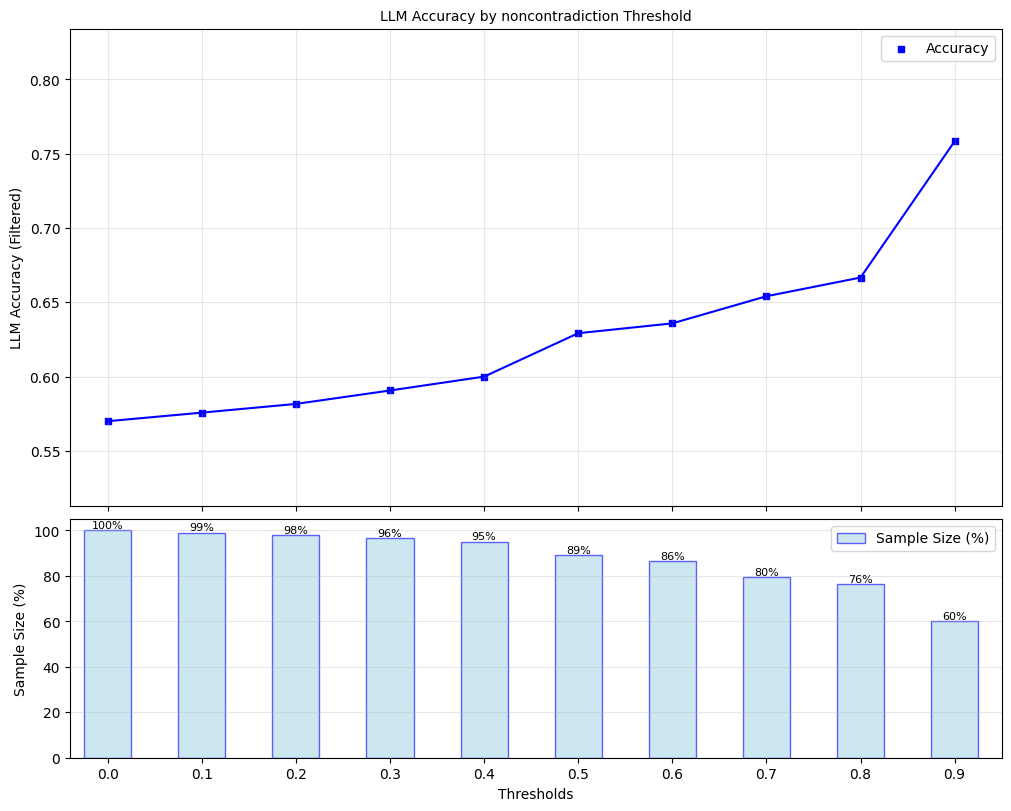

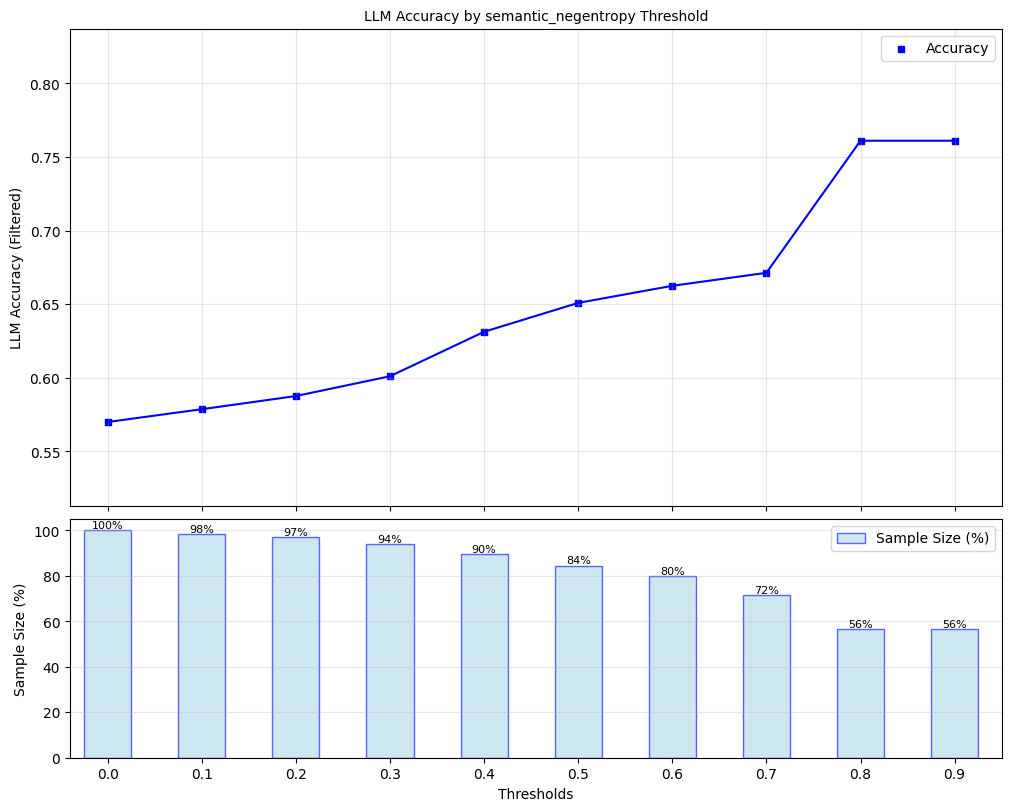

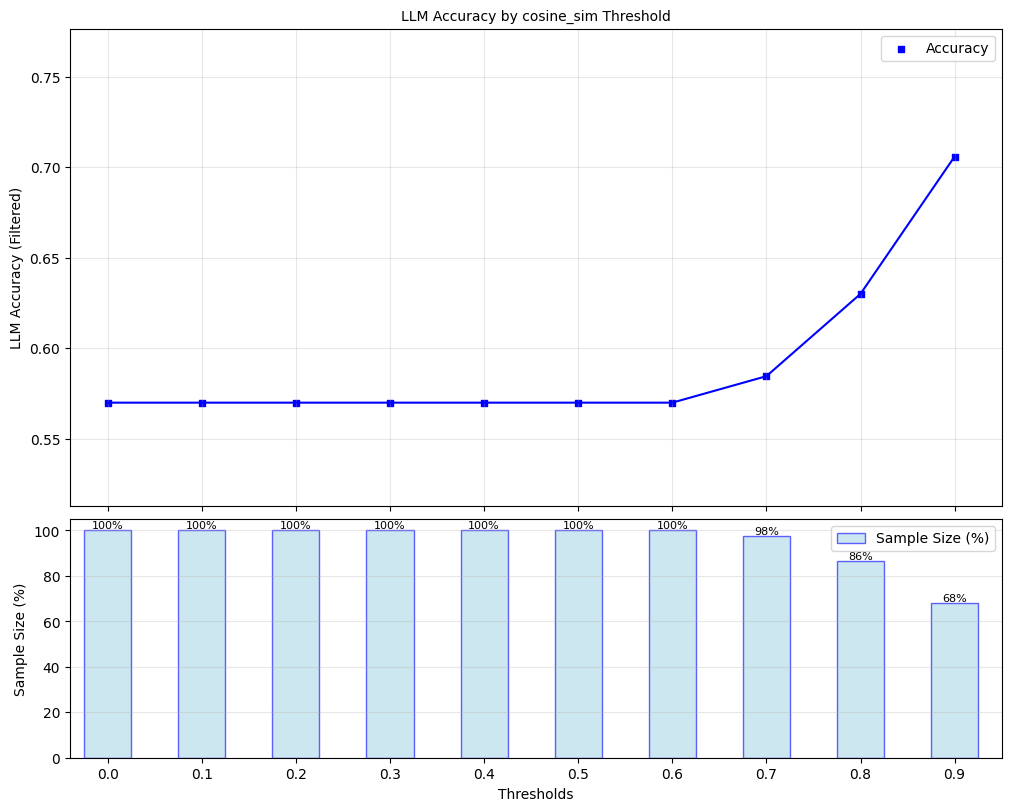

In [12]:
for confidence_score in black_box_scorers:
    plot_model_accuracies(scores=result_df[confidence_score], correct_indicators=result_df.response_correct, title=f"LLM Accuracy by {confidence_score} Threshold", display_percentage=True)

#### 3.2 Precision, Recall, F1-Score of Hallucination Detection

Lastly, we compute the optimal threshold for binarizing confidence scores, using F1-score as the objective. Using this threshold, we compute precision, recall, and F1-score for black box scorer predictions of whether responses are correct.

In [13]:
# instantiate UQLM tuner object for threshold selection
split = len(result_df) // 2
t = Tuner()

correct_indicators = (result_df.response_correct) * 1  # Whether responses is actually correct
metric_values = {"Precision": [], "Recall": [], "F1-score": []}
optimal_thresholds = []
for confidence_score in bbuq.scorers:
    # tune threshold on first half
    y_scores = result_df[confidence_score]
    y_scores_tune = y_scores[0:split]
    y_true_tune = correct_indicators[0:split]
    best_threshold = t.tune_threshold(y_scores=y_scores_tune, correct_indicators=y_true_tune, thresh_objective="fbeta_score")

    y_pred = [(s > best_threshold) * 1 for s in y_scores]  # predicts whether response is correct based on confidence score
    optimal_thresholds.append(best_threshold)

    # evaluate on last half
    y_true_eval = correct_indicators[split:]
    y_pred_eval = y_pred[split:]
    metric_values["Precision"].append(precision_score(y_true=y_true_eval, y_pred=y_pred_eval))
    metric_values["Recall"].append(recall_score(y_true=y_true_eval, y_pred=y_pred_eval))
    metric_values["F1-score"].append(f1_score(y_true=y_true_eval, y_pred=y_pred_eval))

# print results
header = f"{'Metrics':<25}" + "".join([f"{scorer_name:<25}" for scorer_name in bbuq.scorers])
print("=" * len(header) + "\n" + header + "\n" + "-" * len(header))
for metric in metric_values.keys():
    print(f"{metric:<25}" + "".join([f"{round(x_, 3):<25}" for x_ in metric_values[metric]]))
print("-" * len(header))
print(f"{'F-1 optimal threshold':<25}" + "".join([f"{round(x_, 3):<25}" for x_ in optimal_thresholds]))
print("=" * len(header))

Metrics                  noncontradiction         semantic_negentropy      cosine_sim               
----------------------------------------------------------------------------------------------------
Precision                0.726                    0.619                    0.633                    
Recall                   0.818                    0.945                    0.909                    
F1-score                 0.769                    0.748                    0.746                    
----------------------------------------------------------------------------------------------------
F-1 optimal threshold    0.95                     0.52                     0.88                     


## 4. Scorer Definitions
Below we define the scorers offered by the `BlackBoxUQ` class. These scorers exploit variation in LLM responses to the same prompt to measure semantic consistency. These scorers are adapted from the uncertainty quantification literature and have been transformed and normalized, as needed, to have outputs ranging from 0 to 1, where higher values indicate higher confidence. 

For a given prompt $x_i$, these approaches involves generating $m$ responses $\tilde{\mathbf{y}}_i = \{ \tilde{y}_{i1},...,\tilde{y}_{im}\}$, using a non-zero temperature, from the same prompt and comparing these responses to the original response $y_{i}$. We provide detailed descriptions of each below.

### Exact Match Rate (`exact_match`)
Exact Match Rate (EMR) computes the proportion of candidate responses that are identical to the original response.
$$     EMR(y_i; \tilde{\mathbf{y}}_i) = \frac{1}{m} \sum_{j=1}^m \mathbb{I}(y_i=\tilde{y}_{ij}). $$

For more on this scorer, refer to [Cole et al., 2023](https://arxiv.org/abs/2305.14613).

### Non-Contradiction Probability (`noncontradiction`)
Non-contradiction probability (NCP) computes the mean non-contradiction probability estimated by a natural language inference (NLI) model. This score is formally defined as follows:


$$    NCP(y_i; \tilde{\mathbf{y}}_i) = 1 - \frac{1}{m} \sum_{j=1}^m\frac{p_{contra}(y_i, \tilde{y}_{ij}) + p_{contra}(y_i, \tilde{y}_{ij})}{2}. $$


Above, $p_{contra}(y_i, \tilde{y}_{ij})$ denotes the (asymmetric) contradiction probability estimated by the NLI model for response $y_i$ and candidate $\tilde{y}_{ij}$. For more on this scorer, refer to [Chen & Mueller, 2023](https://arxiv.org/abs/2308.16175), [Lin et al., 2024](https://arxiv.org/abs/2305.19187), or [Manakul et al., 2023](https://arxiv.org/abs/2303.08896).

### Entailment Probability (`entailment`)
Entailment probability (EP) computes the mean entailment probability estimated by a natural language inference (NLI) model. This score is formally defined as follows:


$$        EP(y_i; \tilde{\mathbf{y}}_i) = \frac{1}{m} \sum_{j=1}^m\frac{p_{entail}(y_i, \tilde{y}_{ij}) + p_{entail}(y_i, \tilde{y}_{ij})}{2}. $$    


Above, $p_{entail}(y_i, \tilde{y}_{ij})$ denotes the (asymmetric) entailment probability estimated by the NLI model for response $y_i$ and candidate $\tilde{y}_{ij}$. We adapt this scorer from [Chen & Mueller, 2023](https://arxiv.org/abs/2308.16175), [Lin et al., 2024](https://arxiv.org/abs/2305.19187).

### Normalized Semantic Negentropy (`semantic_negentropy`)
Normalized Semantic Negentropy (NSN) normalizes the standard computation of discrete semantic entropy to be increasing with higher confidence and have [0,1] support. In contrast to the EMR and NCP, semantic entropy does not distinguish between an original response and candidate responses. Instead, this approach computes a single metric value on a list of responses generated from the same prompt. Under this approach, responses are clustered using an NLI model based on mutual entailment. We consider the discrete version of SE, where the final set of clusters is defined  as follows:


$$        SE(y_i; \tilde{\mathbf{y}}_i) = - \sum_{C \in \mathcal{C}} P(C|y_i, \tilde{\mathbf{y}}_i)\log P(C|y_i, \tilde{\mathbf{y}}_i), $$    


where $P(C|y_i, \tilde{\mathbf{y}}_i)$ is calculated as the probability a randomly selected response $y \in \{y_i\} \cup \tilde{\mathbf{y}}_i $ belongs to cluster $C$, and $\mathcal{C}$ denotes the full set of clusters of $\{y_i\} \cup \tilde{\mathbf{y}}_i$.

To ensure that we have a normalized confidence score with $[0,1]$ support and with higher values corresponding to higher confidence, we implement the following normalization to arrive at *Normalized Semantic Negentropy* (NSN):

$$        NSN(y_i; \tilde{\mathbf{y}}_i) = 1 - \frac{SE(y_i; \tilde{\mathbf{y}}_i)}{\log m},$$    

where $\log m$ is included to normalize the support. For more on discrete semantic entropy, refer to [Farquhar et al., 2024](https://www.nature.com/articles/s41586-024-07421-0); [Kuhn et al., 2023](https://arxiv.org/pdf/2302.09664), and for more on our normalized version, refer to [Bouchard & Chauhan, 2025](https://arxiv.org/abs/2504.19254).

### Number of Semantic Sets (`semantic_sets_confidence`)
Number of Semantic Sets counts the number of unique response sets (clusters) obtained during the computation of semantic entropy, as defined above. Let $N_C$ denote the number of unique semantic clusters and $m$ denote the number of sampled responses. We normalize this count to obtain a confidence score, Semantic Sets Confidence (SSC) in $[0,1]$ as follows:


$$        SSC(y_i; \tilde{\mathbf{y}}_i) =  \frac{m - N_C}{m - 1}.$$    


Note that when $N_C=1$, all sampled responses are semantically equivalent, so the confidence score is 1, and when $N_C=m$, all responses are semantically distinct, so the confidence score is 0. For more on Number of Semantic Sets, refer to [Lin et al., 2024](https://arxiv.org/abs/2305.19187); [Vashurin et al., 2025](https://arxiv.org/abs/2406.15627); [Kuhn et al., 2023](https://arxiv.org/pdf/2302.09664).

### BERTScore (`bert_score`)
Let a tokenized text sequence be denoted as $\textbf{t} = \{t_1,...t_L\}$ and the corresponding contextualized word embeddings as $\textbf{E} = \{\textbf{e}_1,...,\textbf{e}_L\}$, where $L$ is the number of tokens in the text. The BERTScore precision, recall, and F1-scores between two tokenized texts  $\textbf{t}, \textbf{t}'$ are respectively defined as follows:


$$        BertP(\textbf{t}, \textbf{t}') = \frac{1}{| \textbf{t}|} \sum_{t \in \textbf{t}} \max_{t' \in \textbf{t}'} \textbf{e} \cdot \textbf{e}'$$    



$$        BertR(\textbf{t}, \textbf{t}') = \frac{1}{| \textbf{t}'|} \sum_{t' \in \textbf{t}'} \max_{t \in \textbf{t}} \textbf{e} \cdot \textbf{e}'$$    



$$        BertF(\textbf{t}, \textbf{t}') = 2\frac{ BertP(\textbf{t}, \textbf{t}')  BertR(\textbf{t}, \textbf{t}')}{BertP(\textbf{t}, \textbf{t}')  + BertRec(\textbf{t}, \textbf{t}')},$$    

where $e, e'$ respectively correspond to $t, t'$. We compute our BERTScore-based confidence scores as follows:

$$        BertConf(y_i; \tilde{\mathbf{y}}_i) = \frac{1}{m} \sum_{j=1}^m BertF(y_i, \tilde{y}_{ij}),$$    

i.e. the average BERTScore F1 across pairings of the original response with all candidate responses. For more on BERTScore, refer to [Zheng et al., 2020](https://arxiv.org/abs/1904.09675).


### Normalized Cosine Similarity (`cosine_sim`)
This scorer leverages a sentence transformer to map LLM outputs to an embedding space and measure similarity using those sentence embeddings. Let $V: \mathcal{Y} \xrightarrow{} \mathbb{R}^d$ denote the sentence transformer, where $d$ is the dimension of the embedding space. The average cosine similarity across pairings of the original response with all candidate responses is given as follows:


$$        CS(y_i; \tilde{\mathbf{y}}_i) = \frac{1}{m} \sum_{i=1}^m   \frac{\mathbf{V}(y_i) \cdot \mathbf{V}(\tilde{y}_{ij}) }{ \lVert \mathbf{V}(y_i) \rVert \lVert \mathbf{V}(\tilde{y}_{ij}) \rVert}.$$    


To ensure a standardized support of $[0, 1]$, we normalize cosine similarity to obtain confidence scores as follows:


$$        NCS(y_i; \tilde{\mathbf{y}}_i) = \frac{CS(y_i; \tilde{\mathbf{y}}_i) + 1}{2}.$$    


© 2025 CVS Health and/or one of its affiliates. All rights reserved.